## **Question 2. Object Detection**

### **Initial Setting**

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, ConcatDataset
from PIL import Image
from collections import defaultdict
import os
from ultralytics import YOLO

# Set a fixed seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Choose the device based on availability (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters for training
batch_size = 256  # Number of samples processed before updating the model

Using device: cuda


### **Dataset Loading**

In [2]:
file_path = './dataset/oxford-iiit-pet/annotations/trainval.txt'

# Dictionary to store binary values for each category
cat_dog_values = defaultdict(list)

# Open and read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Split the line into components and parse category and binary values
        parts = line.strip().split()
        category_value = int(parts[1]) - 1  # Adjust category index to be 0-based
        
        # Convert binary values based on specified conditions
        binary_value = int(parts[2])
        if binary_value == 1:
            binary_value = 15
        elif binary_value == 2:
            binary_value = 16

        # Store the converted binary value in the dictionary
        cat_dog_values[category_value].append(binary_value)

# Process the dictionary to store unique binary values where possible
for category_value, binary_values in cat_dog_values.items():
    unique_binary_values = list(set(binary_values))
    
    # If only one unique binary value exists, store it as a single integer
    if len(unique_binary_values) == 1:
        cat_dog_values[category_value] = unique_binary_values[0]
    else:
        cat_dog_values[category_value] = unique_binary_values

# Output the binary values for each category
for category_value, binary_value in cat_dog_values.items():
    print(f"Category {category_value}: binary values = {binary_value}")

Category 0: binary values = 15
Category 1: binary values = 16
Category 2: binary values = 16
Category 3: binary values = 16
Category 4: binary values = 16
Category 5: binary values = 15
Category 6: binary values = 15
Category 7: binary values = 15
Category 8: binary values = 16
Category 9: binary values = 15
Category 10: binary values = 16
Category 11: binary values = 15
Category 12: binary values = 16
Category 13: binary values = 16
Category 14: binary values = 16
Category 15: binary values = 16
Category 16: binary values = 16
Category 17: binary values = 16
Category 18: binary values = 16
Category 19: binary values = 16
Category 20: binary values = 15
Category 21: binary values = 16
Category 22: binary values = 16
Category 23: binary values = 15
Category 24: binary values = 16
Category 25: binary values = 16
Category 26: binary values = 15
Category 27: binary values = 15
Category 28: binary values = 16
Category 29: binary values = 16
Category 30: binary values = 16
Category 31: binar

In [3]:
# Custom transformation function for dataset targets
def target_transform(targets):
    category, mask = targets
    mask = mask_transform(mask)  # Resize the segmentation mask
    mask = np.array(mask)  # Convert mask to a numpy array for further processing
    return category, torch.tensor(mask, dtype=torch.long)  # Return category and tensor mask

# Function to map species label to category
def species_to_category(label):
    return cat_dog_values.get(label, None)

# Update calculate_bounding_box to return a default bounding box if no object is detected
def calculate_bounding_box(mask):
    non_background_indices = torch.nonzero(mask, as_tuple=False)
    
    if non_background_indices.size(0) == 0:  # No non-background pixels
        return torch.tensor([[0, 0, 0, 0]], dtype=torch.float)
    
    ymin = non_background_indices[:, 0].min().item()
    ymax = non_background_indices[:, 0].max().item()
    xmin = non_background_indices[:, 1].min().item()
    xmax = non_background_indices[:, 1].max().item()
    
    return torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float)

class CatDogObjectDetectionDataset(torch.utils.data.Dataset):
    """
    Custom dataset class for object detection with category labels and bounding boxes.
    """
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, (species_label, mask) = self.dataset[idx]
        
        # Map the species label to a cat or dog category
        cat_dog_label = species_to_category(species_label)
        
        if cat_dog_label is None:
            raise ValueError(f"Invalid label encountered: {species_label}")
        
        cat_dog_label = torch.tensor([cat_dog_label], dtype=torch.long)
        
        # Replace mask values with category label (1 for relevant class, 0 for background)
        mask = torch.where(mask == 1, cat_dog_label, torch.tensor(0))
        
        # Calculate bounding box from the mask
        bounding_box = calculate_bounding_box(mask)
        
        return image, bounding_box, cat_dog_label


In [4]:
data_dir = './dataset'
os.makedirs(data_dir, exist_ok=True)  # Create the dataset directory if it doesn't exist

# Image transformations applied to input data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()  # Convert images to PyTorch tensor format
])

# Transformation specifically for segmentation masks
mask_transform = transforms.Resize((256, 256), interpolation=Image.NEAREST)  # Use nearest-neighbor for masks

# Load the Oxford-IIIT Pet dataset for training/validation with categories and segmentation masks
dataset = OxfordIIITPet(
    root=data_dir, 
    split='trainval', 
    target_types=('category', 'segmentation'),  # Load both category labels and segmentation masks
    transform=transform,
    target_transform=target_transform,  # Apply custom transformation to targets
    download=True
)

# Load the test dataset in the same way
test_dataset = OxfordIIITPet(
    root=data_dir, 
    split='test', 
    target_types=('category', 'segmentation'), 
    transform=transform,
    target_transform=target_transform, 
    download=True
)

# Initialize custom datasets for object detection, using the train/val and test splits
cat_dog_dataset = CatDogObjectDetectionDataset(dataset)
cat_dog_test_dataset = CatDogObjectDetectionDataset(test_dataset)

# Combine the training and test datasets
combined_dataset = ConcatDataset([cat_dog_dataset, cat_dog_test_dataset])

# Create DataLoader objects to iterate over the combined dataset with a specified batch size
data_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

Image size: (256, 256, 3), Bounding box: [         60          49         156         208], Class label: 16
Image size: (256, 256, 3), Bounding box: [         92           0         192         215], Class label: 16
Image size: (256, 256, 3), Bounding box: [         50          62         250         206], Class label: 16


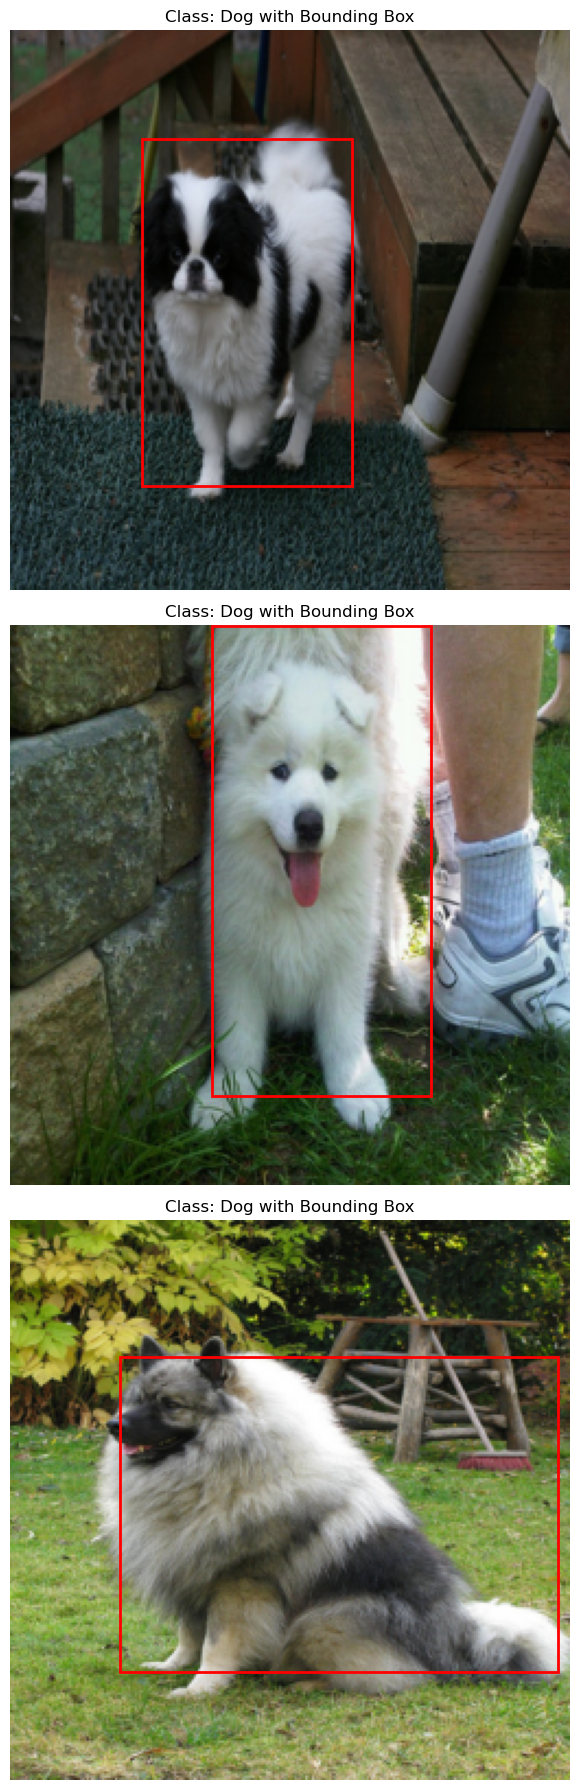

In [5]:
def class_to_name(class_id):
    if class_id == 15:
        return 'Cat'
    elif class_id == 16:
        return 'Dog'
    else:
        return 'Unknown'

def show_images_from_loader_with_bboxes(loader, num_images=3):
    # Get a batch of data from the loader
    data_iter = iter(loader)
    images, bounding_boxes, cat_dog_labels = next(data_iter)
    
    batch_size = len(images)
    num_images = min(num_images, batch_size)

    # Set up a subplot grid for displaying images with bounding boxes
    _, ax = plt.subplots(num_images, 1, figsize=(12, 6 * num_images))
    
    # Ensure ax is a list for consistency even with a single subplot
    if num_images == 1:
        ax = [ax]
    
    for i in range(num_images):
        # Rearrange image dimensions for display (channels last)
        image = images[i].permute(1, 2, 0).numpy()
        bbox = bounding_boxes[i][0].numpy()
        label = cat_dog_labels[i].item()
        
        # Print shape information for debugging purposes
        print(f'Image size: {image.shape}, Bounding box: {bbox}, Class label: {label}')
        
        # Display the image
        ax[i].imshow(image)
        ax[i].set_title(f"Class: {class_to_name(label)} with Bounding Box")
        ax[i].axis('off')
        
        # Draw bounding box if available
        if bbox is not None:
            xmin, ymin, xmax, ymax = bbox
            # Create a rectangle patch for the bounding box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            # Add the rectangle patch to the plot
            ax[i].add_patch(rect)
    
    # Show the plot with images and bounding boxes
    plt.tight_layout()
    plt.show()

# Show 3 image-bounding box pairs from the data loader
show_images_from_loader_with_bboxes(data_loader, num_images=3)

### **Predict Cats and Dogs with YOLOv3**

In [6]:
def predict_and_evaluate(model, data_loader, device, num_examples):
    pred_boxes = []  # Store predicted boxes, scores, and labels
    gt_boxes = []    # Store ground-truth boxes and labels
    example_images = []  # Store a limited number of example images for visualization
    
    for _, (images, bounding_boxes, labels) in enumerate(data_loader):
        images = images.to(device)
        model.to(device)

        # Run the model on the batch of images
        results = model(images)

        for i in range(len(images)):
            # Collect predicted bounding boxes, scores, and labels for each image
            pred_boxes.append({
                'boxes': results[i].boxes.xyxy.to(device),
                'scores': results[i].boxes.conf.to(device),
                'labels': results[i].boxes.cls.to(device)
            })

            # Add ground-truth boxes and labels to gt_boxes
            gt_boxes.append({
                'boxes': bounding_boxes[i].to(device),
                'labels': labels[i].to(device)
            })

        # Collect example images up to the specified num_examples for visualization
        if len(example_images) < num_examples:
            example_images.extend(images[:num_examples - len(example_images)].cpu())

    return pred_boxes, gt_boxes, example_images

In [7]:
# Initialize the YOLO model and load it onto the specified device
model = YOLO("yolov3u.pt").to(device)

# Set the number of example images to visualize
num_examples = 3

# Run predictions and evaluation on the data loader
pred_boxes, gt_boxes, example_images = predict_and_evaluate(model, data_loader, device, num_examples)

c:\Users\qube2\anaconda3\envs\cs512\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0: 256x256 1 bear, 7.1ms
1: 256x256 1 cat, 1 bed, 7.1ms
2: 256x256 1 dog, 1 chair, 7.1ms
3: 256x256 1 person, 1 dog, 7.1ms
4: 256x256 1 cat, 7.1ms
5: 256x256 1 cat, 2 chairs, 7.1ms
6: 256x256 1 dog, 7.1ms
7: 256x256 1 cat, 1 bed, 7.1ms
8: 256x256 1 dog, 7.1ms
9: 256x256 2 dogs, 1 couch, 7.1ms
10: 256x256 1 dog, 7.1ms
11: 256x256 1 person, 1 dog, 7.1ms
12: 256x256 1 cat, 7.1ms
13: 256x256 1 dog, 7.1ms
14: 256x256 1 dog, 1 couch, 7.1ms
15: 256x256 1 cat, 7.1ms
16: 256x256 1 cat, 7.1ms
17: 256x256 1 cat, 7.1ms
18: 256x256 1 dog, 7.1ms
19: 256x256 1 cat, 1 bed, 7.1ms
20: 256x256 1 dog, 1 bed, 7.1ms
21: 256x256 1 cat, 1 couch, 7.1ms
22: 256x256 1 car, 1 dog, 7.1ms
23: 256x256 1 dog, 1 sports ball, 7.1ms
24: 256x256 1 cat, 1 bed, 7.1ms
25: 256x256 1 dog, 7.1ms
26: 256x256 1 person, 1 car, 1 dog, 7.1ms
27: 256x256 1 dog, 1 remote, 7.1ms
28: 256x256 1 dog, 7.1ms
29: 256x256 1 person, 1 dog, 7.1ms
30: 256x256 1 cat, 7.1ms
31: 256x256 1 dog, 7.1ms
32: 256x256 1 dog, 7.1ms
33: 256x256 1 dog, 7.1m

### **Display Results with Bounding Boxes**

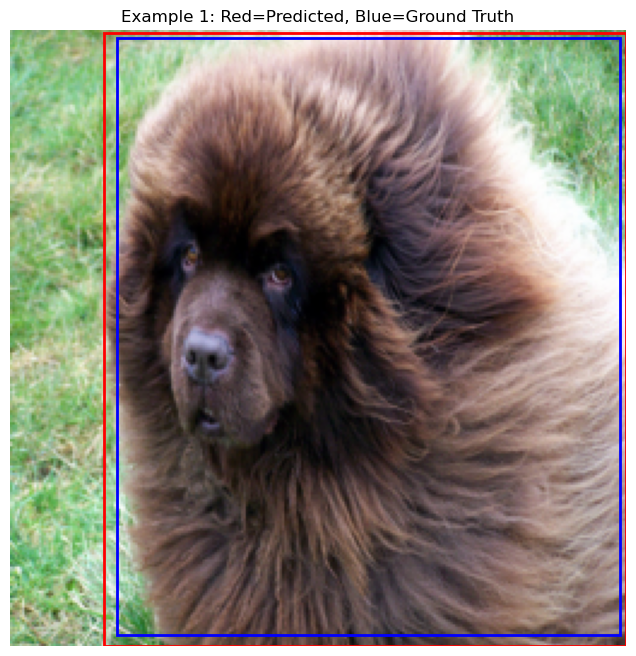

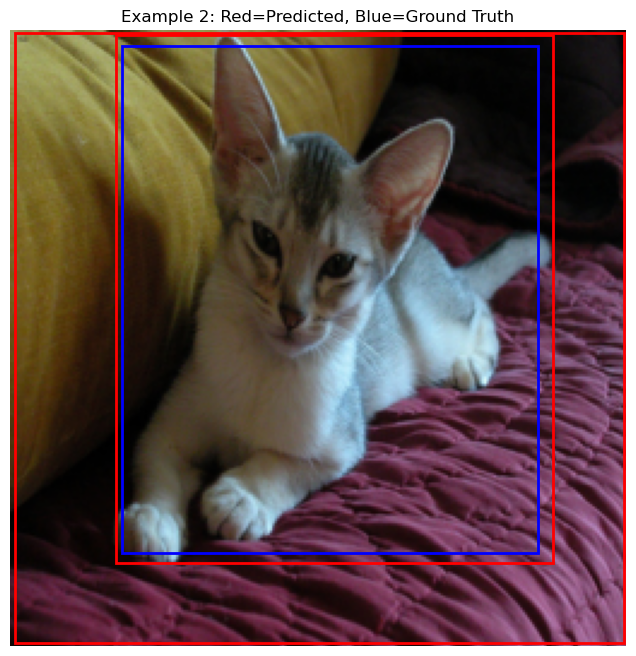

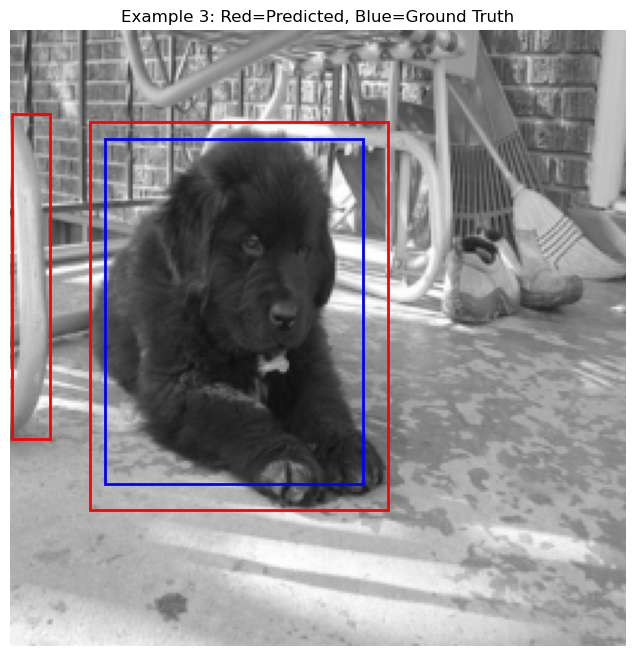

In [8]:
def display_examples(images, pred_boxes, gt_boxes, num_examples=3):
    num_images = min(num_examples, len(images))

    for i in range(num_images):
        # Convert image tensor to numpy format for plotting
        img = images[i].permute(1, 2, 0).cpu().numpy()

        fig, ax = plt.subplots(1, figsize=(8, 8))  # Adjust figure size for better visualization
        ax.imshow(img)

        # Plot predicted boxes in red
        for box in pred_boxes[i]['boxes']:
            box = box.cpu().numpy()
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Plot ground-truth boxes in blue
        for box in gt_boxes[i]['boxes']:
            box = box.cpu().numpy()
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)

        # Set the title and display the plot
        ax.set_title(f"Example {i+1}: Red=Predicted, Blue=Ground Truth")
        ax.axis('off')  # Turn off axis for cleaner display
        plt.show()

# Display 3 examples with predicted and ground-truth bounding boxes
display_examples(example_images, pred_boxes[:num_examples], gt_boxes[:num_examples], num_examples)

### **Calculate mAP with Different IoU Thresholds**

In [9]:
def load_labels(label_path, is_prediction=False):
    labels = {}
    with open(label_path, 'r') as file:
        for line in file:
            data = line.strip().split()
            image_id = data[0]
            bbox_values = list(map(float, data[1].split(',')))
            xmin, ymin, xmax, ymax = map(float, bbox_values[:4])
            class_id = int(bbox_values[4])
            confidence = float(bbox_values[5]) if is_prediction else None
            # Store bounding box, class, and confidence (if prediction) for each image
            labels[image_id] = {
                "bbox": [xmin, ymin, xmax, ymax],
                "class": class_id,
                "confidence": confidence
            }
    return labels

def calculate_iou(bbox1, bbox2):
    # Calculate intersection coordinates
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    # Calculate intersection and union areas
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    # Compute IoU
    iou = inter_area / float(bbox1_area + bbox2_area - inter_area)
    return iou

def calculate_map(gt_labels, pred_labels, iou_threshold):
    true_positives = []
    false_positives = []
    confidences = []

    for image_id in pred_labels:
        pred = pred_labels[image_id]
        gt = gt_labels.get(image_id)

        if gt is not None:
            iou = calculate_iou(gt["bbox"], pred["bbox"])
            # Check if IoU exceeds threshold and classes match
            if gt["class"] == pred["class"] and iou >= iou_threshold:
                true_positives.append(1)
                false_positives.append(0)
            else:
                true_positives.append(0)
                false_positives.append(1)
            confidences.append(pred["confidence"])

    if not true_positives:
        return 0.0

    # Sort predictions by confidence (descending)
    sorted_indices = np.argsort(confidences)[::-1]
    true_positives = np.array(true_positives)[sorted_indices]
    false_positives = np.array(false_positives)[sorted_indices]

    # Calculate cumulative sums of true positives and false positives
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)

    # Calculate precision and recall
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
    recalls = tp_cumsum / (len(gt_labels) + 1e-10)

    # Compute Average Precision (AP)
    average_precision = 0.0
    for i in range(len(precisions)):
        # Sum precision differences weighted by recall steps
        average_precision += precisions[i] * (recalls[i] - recalls[i - 1] if i > 0 else recalls[i])

    return average_precision

# Define IoU thresholds
iou_thresholds = [0.25, 0.5, 0.75, 0.95]

# Load ground truth and prediction labels
gt_labels = load_labels('./gt_label.txt', is_prediction=False)
pred_labels = load_labels('./pred_label.txt', is_prediction=True)

# Calculate and print mAP for each IoU threshold
mean_average_precision = 0.0
for threshold in iou_thresholds:
    map_score = calculate_map(gt_labels, pred_labels, iou_threshold=threshold)
    print(f"mAP at IoU threshold {threshold}: {map_score:.4f}")

mAP at IoU threshold 0.25: 0.8594
mAP at IoU threshold 0.5: 0.8334
mAP at IoU threshold 0.75: 0.6945
mAP at IoU threshold 0.95: 0.0019
